In [89]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np

from pa_lib.file import store_bin, project_dir, data_files, load_csv, load_bin, write_xlsx
from pa_lib.data import as_dtype, dtFactor, desc_col, lookup, clean_up_categoricals
from pa_lib.log import time_log
from pa_lib.types import Record

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [238]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_labels = load_bin("ax_var_labels.feather")

var = Record(**{v: v for v in np.unique(ax_data.Variable)})

weekday_order = "Monday Tuesday Wednesday Thursday Friday Saturday Sunday".split()

2019-09-24 18:26:15 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
2019-09-24 18:26:15 [INFO] Finished loading binary file in 0.1s (0.42s CPU)
2019-09-24 18:26:15 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_labels.feather
2019-09-24 18:26:15 [INFO] Finished loading binary file in 0.0s (0.0s CPU)


In [231]:
def var_label(variable):
    return ax_var_labels.set_index("Variable").at[variable, "Label"]

In [232]:
desc_col(ax_data, det=True)

,DTYPE,NULLS,UNIQUE,MEM,RANGE
Station,category,0/5874074,27,5.6 MB,"[Aarau,Zürich Stadelhofen]"
DayOfWeek,category,0/5874074,7,5.6 MB,"[Monday,Sunday]"
Time,category,0/5874074,98,5.6 MB,"[00:00 - 00:15,23:45 - 00:00]"
Variable,category,0/5874074,117,5.6 MB,"[g_220,nat_ausland]"
Code,category,0/5874074,155,11.2 MB,"[1 - 4 Flüge,Über den lokalen TV-Kabelanbieter (nicht Cablecom)]"
Value,float64,0/5874074,318045,44.8 MB,"[0.47903999999999997,58.059993773]"
Year,category,0/5874074,1,5.6 MB,"[2019,2019]"
Month,category,0/5874074,4,5.6 MB,"[05,08]"
logValue,float64,0/5874074,318045,44.8 MB,"[-0.7359711777508736,4.0614768513453585]"
Station_Time,category,0/5874074,2424,11.5 MB,"[Aarau 00:00 - 00:15,Zürich Stadelhofen 23:45 - 00:00]"


## Define code order, where necessary

In [205]:
var_code_order = {
    "md_ek": {
        "Keine Angabe": 0,
        "Weniger als 3'000 CHF": 1,
        "Zwischen 3'000 und 4'500 CHF": 2,
        "Zwischen 4'501 und 6'000 CHF": 3,
        "Zwischen 6'001 und 9'000 CHF": 4,
        "Zwischen 9'001 und 12'000 CHF": 5,
        "Mehr als 12'000 CHF": 6,
    },
    "md_agenatrep": {
        "14-29 Jahre": 1,
        "30-45 Jahre": 2,
        "46-60 Jahre": 3,
        "61+ Jahre": 4,
    },
    "md_bildung3": {
        "niedrig (kein Abschluss, obligat. Schule, HH-Lehrjahr, Handelsschule, Anlehre)": 1,
        "mittel (Diplommittelschule, allg. Schule, Berufslehre, Vollzeitberufsschule, Maturität, Lehrerseminar)": 2,
        "hoch (Universität, ETH, FH, PH, höhere Berufsausbildung)": 3,
    },
    "md_hhgr3": {"1 Person": 1, "2 Personen": 2, "3+ Personen": 3},
    "g_privatetrainuse": {
        "Nie": 1,
        "1-2 Mal jährlich": 2,
        "3-12 Mal jährlich": 3,
        "2-5 Mal pro Monat": 4,
        "6 Mal pro Monat oder häufiger": 5,
    },
    "md_203": {   # Bahnnutzung beruflich
        "Nie": 1,
        "Seltener": 2,
        "Etwa zu einem Viertel": 3,
        "Etwa zur Hälfte": 4,
        "Meistens": 5,
        "Immer": 6,
    },
}

# Check distributions

## Time

In [29]:
ax_data.Time.value_counts()

17:15 - 17:30    107149
17:30 - 17:45    106533
17:00 - 17:15    104639
17:45 - 18:00    104014
18:00 - 18:15    103498
16:45 - 17:00    101848
18:15 - 18:30    100640
16:30 - 16:45    100318
16:15 - 16:30     97879
18:30 - 18:45     97811
16:00 - 16:15     94720
18:45 - 19:00     91825
15:45 - 16:00     91231
20:45 - 21:00     89540
15:15 - 15:30     88789
15:30 - 15:45     88349
19:00 - 19:15     88234
08:15 - 08:30     88020
15:00 - 15:15     86624
07:30 - 07:45     86469
07:45 - 08:00     86340
12:00 - 12:15     86012
12:15 - 12:30     85929
13:30 - 13:45     85875
08:30 - 08:45     85797
08:00 - 08:15     85773
13:15 - 13:30     85140
13:00 - 13:15     84245
07:15 - 07:30     83922
14:45 - 15:00     83833
19:15 - 19:30     83622
12:30 - 12:45     83240
11:45 - 12:00     82982
13:45 - 14:00     82226
12:45 - 13:00     81453
14:30 - 14:45     81265
11:30 - 11:45     80801
11:15 - 11:30     80350
19:30 - 19:45     80284
09:45 - 10:00     79761
14:15 - 14:30     79520
14:00 - 14:15   

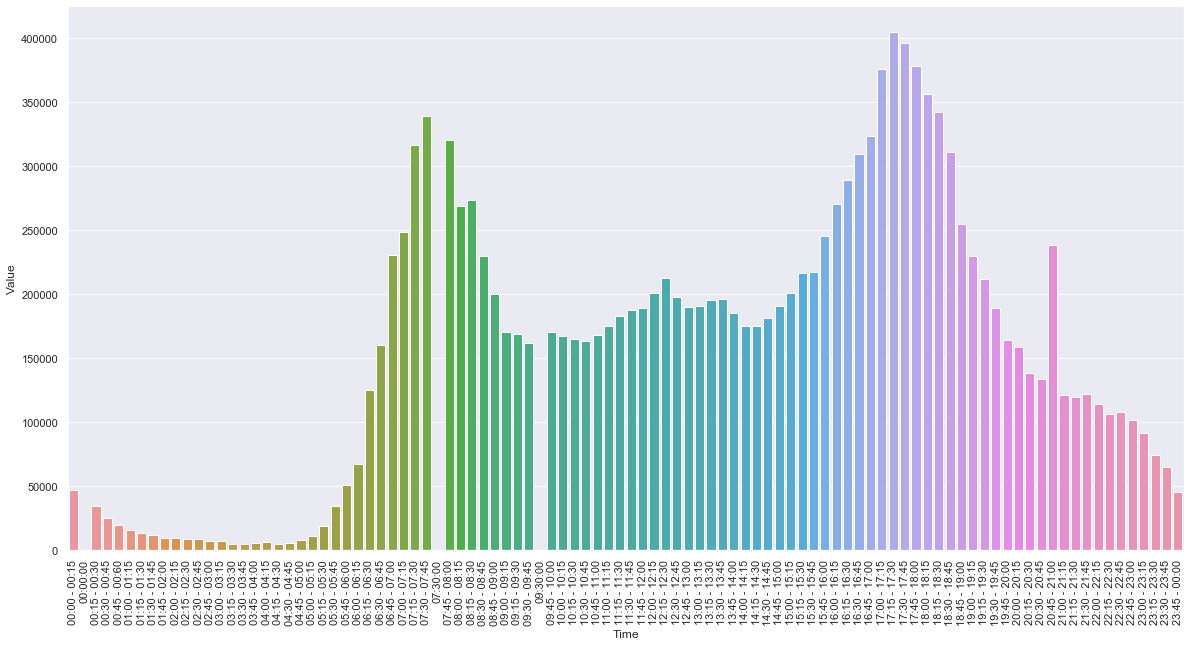

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
plt.figure(figsize=(20, 10))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Time", y="Value", ci=None, estimator=np.sum)

In [ ]:
ax_data.query("Time=='00:00:00'")

### Time by Weekday

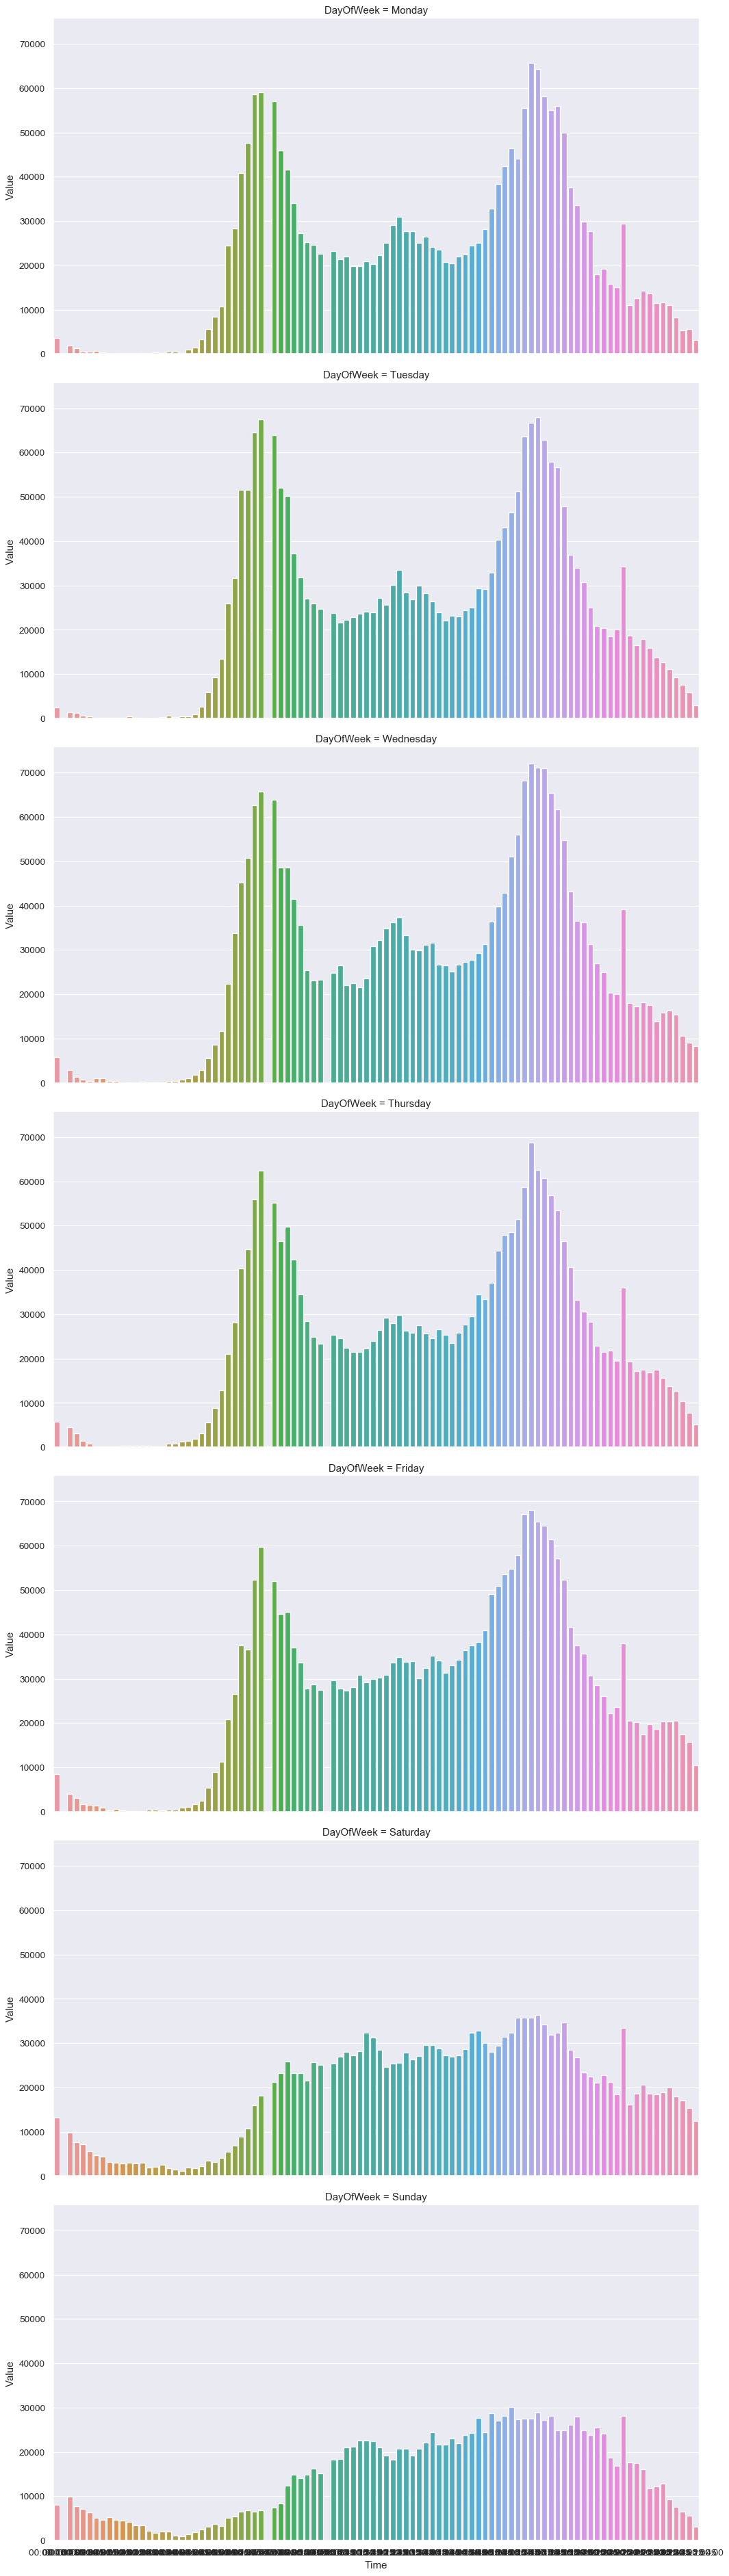

In [239]:
sns.catplot(
    data=ax_data,
    kind="bar",
    x="Time",
    y="Value",
    row="DayOfWeek",
    row_order=weekday_order,
    ci=None,
    estimator=np.sum,
    height=6,
    aspect=2,
)

## Stations

In [ ]:
ax_data.Station.value_counts()

In [ ]:
plt.figure(figsize=(16, 10))
plt.xticks(rotation=90)

sns.barplot(data=ax_data, x="Station", y="Value", ci=None, estimator=np.sum)

## Weekdays

In [ ]:
ax_data.DayOfWeek.value_counts()

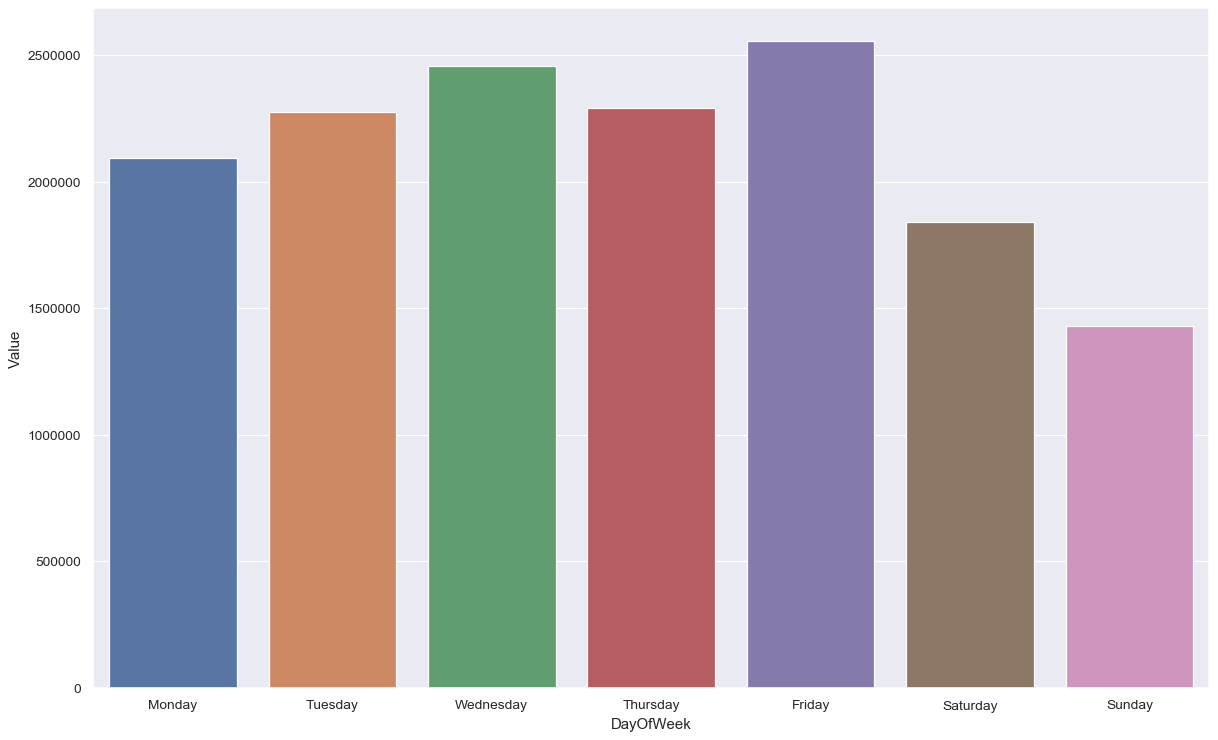

In [240]:
plt.figure(figsize=(16, 10))

sns.barplot(
    data=ax_data,
    x="DayOfWeek",
    y="Value",
    ci="sd",
    estimator=np.sum,
    order=weekday_order,
)

# Tests for Independence

In [57]:
def table_stats(variable, factor, partitions):
    data = ax_data.loc[ax_data.Variable == variable]
    result = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
    for label, subset in data.groupby(partitions):
        result_row = {"Var": variable, "Label": label}
        contingency_tab = subset.pivot_table(
            index="Code", columns=factor, aggfunc="size", fill_value=0, observed=True
        )
        p_factor = chi2_contingency(contingency_tab)[1]
        result_row[f"p_{factor}"] = p_factor
        result = result.append(result_row, ignore_index=True, sort=False)
    return result

## For all variables, find stations where the distribution of codes is dependent on day time

In [58]:
%%time
factor = "Time"
partitions = ["Station"]

all_var_assoc = pd.DataFrame(columns=["Var", "Label", f"p_{factor}"])
for v in var:
    var_assoc = table_stats(v, factor=factor, partitions=partitions)
    all_var_assoc = all_var_assoc.append(
        var_assoc.loc[var_assoc[f"p_{factor}"] <= 0.05], ignore_index=True, sort=False
    )
    
all_var_assoc = lookup(
    src_df=all_var_assoc,
    src_id_col="Var",
    target_df=ax_var_labels,
    target_id_col="Variable",
    target_col="Label",
    new_col="VarDesc",
)

Wall time: 1min 7s


In [69]:
var_stations = pd.crosstab(
    index=all_var_assoc.VarDesc, columns=all_var_assoc.Label, margins=True
)

In [61]:
with project_dir("axinova"):
    write_xlsx(var_stations, "var_by_station.xlsx", "contigency tab")

2019-09-24 14:58:51 [INFO] Writing to file C:\Users\kpf\data\axinova\var_by_station.xlsx
2019-09-24 14:58:51 [INFO] Written 21.1 KB
2019-09-24 14:58:51 [INFO] Finished writing xlsx file in 0.07s (0.09s CPU)


### Which variables have the most stations where their codes are time-dependent?

In [80]:
all_var_assoc.groupby("Var").agg({"VarDesc": "max", "Label": "size"}).sort_values(
    "Label", ascending=False
)

,VarDesc,Label
Var,,
md_880,Parteipräferenz,22
md_ek,Haushaltsbruttoeinkommen pro Monat,21
md_403,Internetanbieter,20
md_hhverm,frei verfügbares Vermögen Haushalt,18
md_203,Bahnnutzung pro Jahr: Berufstätige/In Ausbildung beruflich,17
md_923,Oberes Management,17
md_agenatrep,Alter nach 4 Kategorien,17
md_berufgroup,Berufsgruppe,15
md_925,Abteilungs-/Teamleitung,15


### Which stations have the most variables whose codes are time-dependent?

In [78]:
all_var_assoc.groupby("Label").agg({"Var": "size"}).sort_values(
    "Var", ascending=False
)

,Var
Label,
Lausanne,59
Lugano,58
Bellinzona,53
Zürich Hardbrücke,52
Genève Cornavin,49
Neuchatel,48
St. Gallen,46
Aarau,45
Zug,44


## For a single variable, show distribution of codes over time

In [254]:
import altair as alt

alt.data_transformers.enable("default", max_rows=None)


def plot_var_time_dist(data, variable, over, station, as_percent=False):
    subset = (
        data.query("Station == @station and Variable == @variable")
        .pipe(clean_up_categoricals)
        .copy()
    )
    codes_sorted = variable in var_code_order
    if codes_sorted:
        subset["Code_order"] = subset["Code"].replace(var_code_order[variable])
        code_list_sorted = list(var_code_order[variable])
    chart = (
        alt.Chart(subset)
        .mark_bar()
        .encode(
            x=alt.X("sum(Value)", stack="normalize") if as_percent else "sum(Value)",
            y=alt.Y(over, sort=weekday_order if over == "DayOfWeek" else "ascending"),
            color=alt.Color(
                "Code",
                sort=code_list_sorted if codes_sorted else "ascending",
                scale=alt.Scale(scheme="spectral" if codes_sorted else "category20"),
            ),
            order=alt.Order("Code_order") if codes_sorted else alt.Order("Code"),
        )
        .configure_view(width=800)
        .properties(
            title=f"{var_label(variable)} | {over} [{station}]"
            + (", Prozent" if as_percent else "")
        )
    )
    return chart

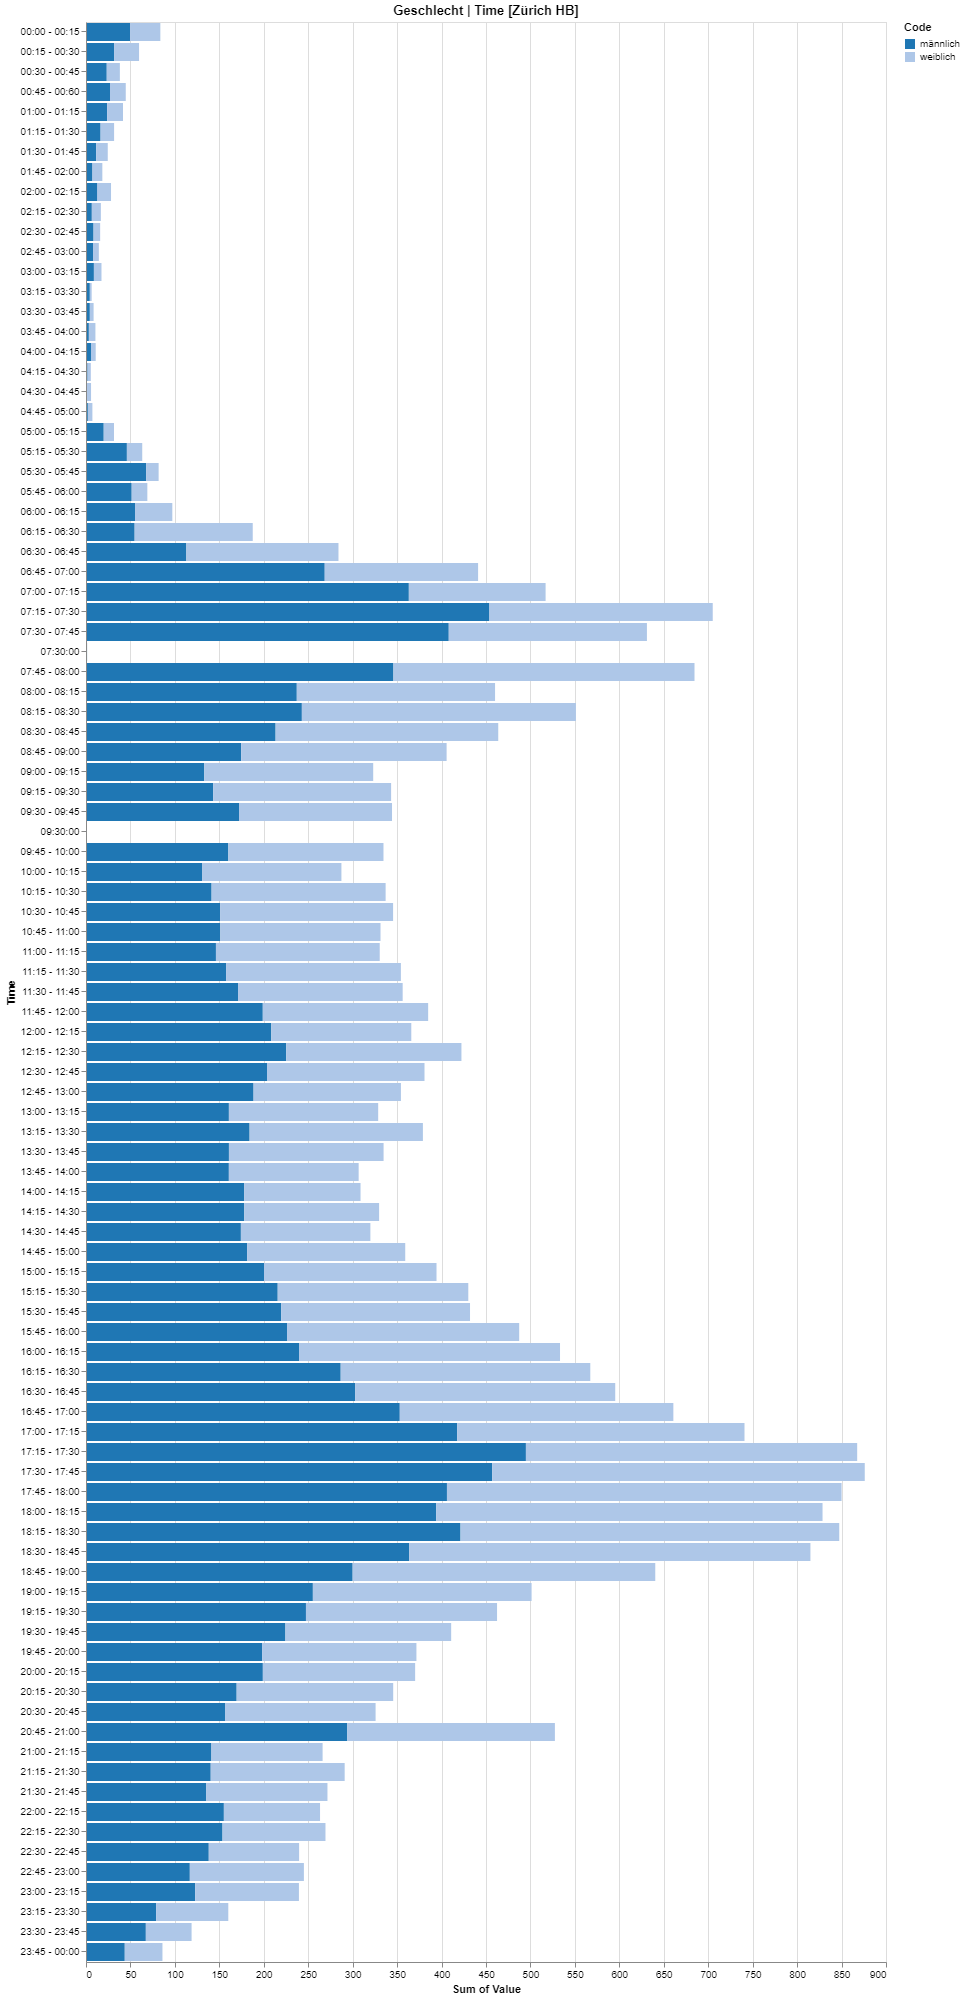

In [260]:
plot_var_time_dist(
    data=ax_data,
    variable="md_sex",
    over="Time",
    station="Zürich HB",
    as_percent=False,
)